In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
uploaded = files.upload()

Saving bank-full.csv to bank-full.csv


In [64]:
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, sep=';')

In [9]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [65]:
# Выбор нужных столбцов
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing',
           'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
           'previous', 'poutcome', 'y']
df = df[columns]

In [72]:
df_new = df[columns]
df_new.isnull().sum()

,0
age,0
job,0
marital,0
education,0
balance,0
housing,0
contact,0
day,0
month,0
duration,0


In [67]:
# Вопрос 1:
df_new['education'].mode()

,education
0,secondary


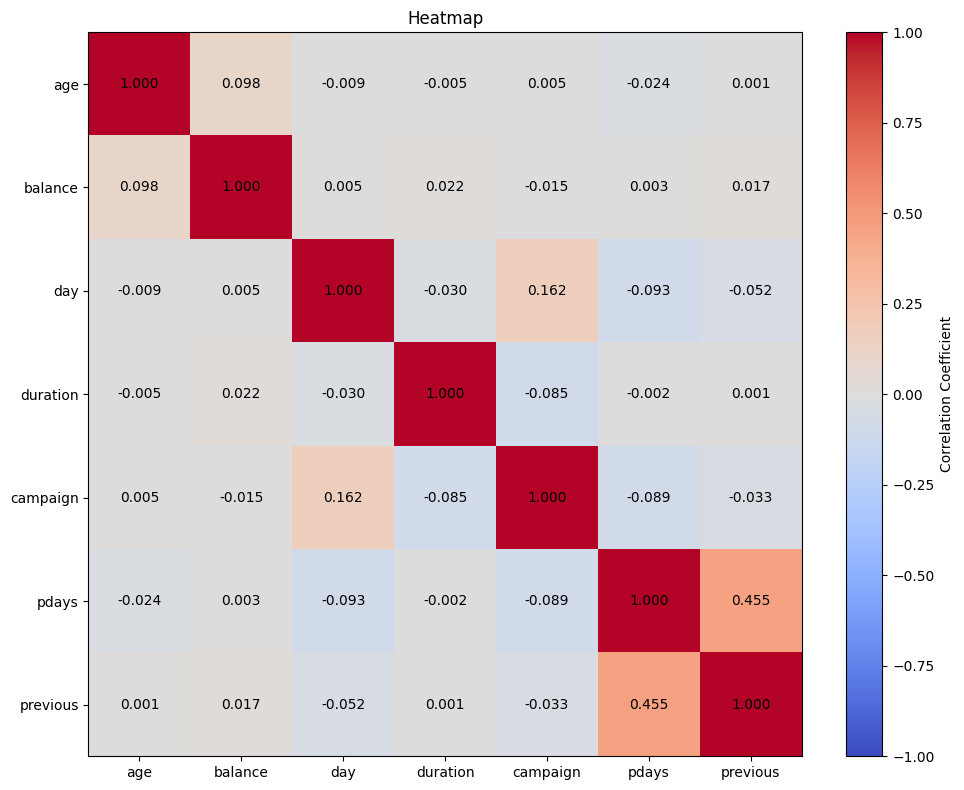

pdays и previous: 0.455
day и campaign: 0.162
age и balance: 0.098


In [57]:
# Вопрос 2:
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
correlation_matrix = df[numeric_columns].corr()

# Строим heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

plt.xticks(range(len(numeric_columns)), numeric_columns, rotation=0)
plt.yticks(range(len(numeric_columns)), numeric_columns)

cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

for i in range(len(numeric_columns)):
    for j in range(len(numeric_columns)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=10)

plt.title('Heatmap')
plt.tight_layout()
plt.show()

corr_pairs = []
for i in range(len(numeric_columns)):
    for j in range(i+1, len(numeric_columns)):
        corr_pairs.append({
            'pair': f"{numeric_columns[i]} и {numeric_columns[j]}",
            'correlation': abs(correlation_matrix.iloc[i, j])
        })

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: x['correlation'], reverse=True)
for pair in corr_pairs_sorted[:3]:
    print(f"{pair['pair']}: {pair['correlation']:.3f}")



In [73]:
df_new['y'] = df_new['y'].map({'yes': 1, 'no': 0})

X = df_new.drop('y', axis=1)
y = df_new['y']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [77]:
# Вопрос 3:
categorical_columns = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

mi_scores = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_col = le.fit_transform(X_train[col].fillna('missing'))

    mi = mutual_info_classif(encoded_col.reshape(-1, 1), y_train)[0]
    mi_scores[col] = round(mi, 2)

for col, score in sorted(mi_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {score}")

poutcome: 0.03
contact: 0.02
month: 0.02
job: 0.01
marital: 0.01
housing: 0.01
education: 0.0


In [ ]:
# Вопрос 4

# One-hot кодирование
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_val_encoded = pd.get_dummies(X_val, columns=categorical_columns)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_encoded, y_train)
y_val_pred = model.predict(X_val_encoded)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"{accuracy:.2f}")

0.90


In [98]:
# Вопрос 5
base_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Исходная точность: {base_accuracy:.3f}")

features_to_test = ['age', 'balance', 'marital', 'previous']
accuracy_differences = {}

for feature in features_to_test:
    X_train_reduced = X_train.drop(feature, axis=1)
    X_val_reduced = X_val.drop(feature, axis=1)

    X_train_reduced_encoded = pd.get_dummies(X_train_reduced, columns=[col for col in categorical_columns if col != feature])
    X_val_reduced_encoded = pd.get_dummies(X_val_reduced, columns=[col for col in categorical_columns if col != feature])

    missing_cols = set(X_train_reduced_encoded.columns) - set(X_val_reduced_encoded.columns)
    for col in missing_cols:
        X_val_reduced_encoded[col] = 0
    X_val_reduced_encoded = X_val_reduced_encoded[X_train_reduced_encoded.columns]

    model_reduced = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_reduced.fit(X_train_reduced_encoded, y_train)
    y_val_pred_reduced = model_reduced.predict(X_val_reduced_encoded)

    reduced_accuracy = accuracy_score(y_val, y_val_pred_reduced)
    difference = base_accuracy - reduced_accuracy
    accuracy_differences[feature] = difference

min_diff_feature = min(accuracy_differences, key=lambda x: abs(accuracy_differences[x]))
print(f"Наименьшая разница у признака: {min_diff_feature}")

Исходная точность: 0.898
Наименьшая разница у признака: age


In [101]:
# Вопрос 6: Регуляризация
best_accuracy = 0
best_c = None

for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train_encoded, y_train) #
    y_val_pred = model.predict(X_val_encoded)
    accuracy_val = accuracy_score(y_val, y_val_pred)

    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_c = C

print(best_c)

0.1


# Ответы на вопросы:
1) Какое самое частое значение (mode) для столбца education? -- secondary
2) Какие два признака имеют наибольшую корреляцию? -- age и balance
3) Какая из этих переменных имеет наибольшую взаимную информацию? -- poutcome
4) Точность на валидационном наборе данных -- 0.9
5) Какой из признаков имеет наименьшую разницу? -- age
6) Какое из значений C приводит к наилучшей точности на валидационном наборе? -- 0.1
